# 모델러닝 중 전처리 작업을 위해 만든 파일

In [3]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pyarrow.parquet as pq
import tqdm
import optuna

# test 데이터 준비 (샘플로 train에서 분리)
from sklearn.model_selection import train_test_split

# 모델 학습 및 평가
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score


# notebook이 있는 디렉토리를 절대경로로 설정
notebook_dir = r'c:\Users\Administrator\github\Credit-Card-Segment\LGW'

# sys.path에 추가 (중복 확인)
if notebook_dir not in sys.path:
    sys.path.insert(0, notebook_dir)

# 작업 디렉토리 변경
os.chdir(notebook_dir)
from corr_dict import corr_dict

c:\Users\Administrator\miniconda3\envs\Sub\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
HOME = os.getcwd()
list_dir = os.listdir(HOME)

In [5]:
list_dir

['1.corr.common.txt',
 '1.corr.txt',
 '2.corr.txt',
 '240_Segment.parquet',
 '3.corr.txt',
 '4.corr.txt',
 '5.corr.txt',
 '6.corr.txt',
 '7.corr.txt',
 '8.corr.txt',
 'catboost_info',
 'corr_dict.py',
 'corr_Name_backup.txt',
 'credit_preprocessing_month_10.parquet',
 'credit_preprocessing_month_11.parquet',
 'credit_preprocessing_month_12.parquet',
 'credit_preprocessing_month_7.parquet',
 'credit_preprocessing_month_8.parquet',
 'credit_preprocessing_month_9.parquet',
 'data',
 'Data_Analysis.ipynb',
 'Data_Analysis_Lite.ipynb',
 'Data_Analysis_Sub.ipynb',
 'LGW Read me',
 'merge_data.ipynb',
 'merge_data_feedback.ipynb',
 'Segment_Correlation_Pearson',
 'Segment_Correlation_Spearman.txt',
 'test',
 '__pycache__']

### 시작 전 준비
 - 858개라는 방대한 데이터를 가지게 됬지만, 이는 세부적인 사항을 고려하지 못할수도 있다. 따라서, 나중에 세부사항을 파악하기 위해서 따로 사용할 코드를 하나 더 만들어 놓는다.

In [6]:
# 각 폴더명 딕셔너리
folder_name = {1:"1.회원정보", 2:"2.신용정보", 3:"3.승인매출정보", 4:"4.청구입금정보", 5:"5.잔액정보", 6:"6.채널정보", 7:"7.마케팅정보", 8:"8.성과정보"}

# 현재 디렉터리
HOME = os.getcwd()

# 폴더 리스트를 생성하고 폴더 경로들을 리스트로 저장하기
folder_list = []
for value in folder_name.values():
    folder_list.append(os.path.join(HOME, "data", "train", value))
print(len(folder_list))

# 폴더 내 파일 리스트 읽어오기
fileNameList = {}
for i in range(len(folder_list)):
    fileNameList[i+1] = os.listdir(folder_list[i])
print(fileNameList)

# 파일 경로 리스트 생성
filePathList = {}
temp = []
for i in range(len(folder_list)):
    for j in range(len(fileNameList[i+1])):
        temp.append(os.path.join(folder_list[i], fileNameList[i+1][j]))
    filePathList[i+1] = temp
    temp = []

print(filePathList)

8
{1: ['201807_train_회원정보.parquet', '201808_train_회원정보.parquet', '201809_train_회원정보.parquet', '201810_train_회원정보.parquet', '201811_train_회원정보.parquet', '201812_train_회원정보.parquet'], 2: ['201807_train_신용정보.parquet', '201808_train_신용정보.parquet', '201809_train_신용정보.parquet', '201810_train_신용정보.parquet', '201811_train_신용정보.parquet', '201812_train_신용정보.parquet'], 3: ['201807_train_승인매출정보.parquet', '201808_train_승인매출정보.parquet', '201809_train_승인매출정보.parquet', '201810_train_승인매출정보.parquet', '201811_train_승인매출정보.parquet', '201812_train_승인매출정보.parquet'], 4: ['201807_train_청구정보.parquet', '201808_train_청구정보.parquet', '201809_train_청구정보.parquet', '201810_train_청구정보.parquet', '201811_train_청구정보.parquet', '201812_train_청구정보.parquet'], 5: ['201807_train_잔액정보.parquet', '201808_train_잔액정보.parquet', '201809_train_잔액정보.parquet', '201810_train_잔액정보.parquet', '201811_train_잔액정보.parquet', '201812_train_잔액정보.parquet'], 6: ['201807_train_채널정보.parquet', '201808_train_채널정보.parquet', '201809_train_채널정보.parquet',

In [7]:
# list에 나중에 불러올 파일들을 저장하기
df_list = list(filter(lambda x: x.endswith('.parquet'), list_dir))
df_list = sorted(df_list, key=lambda x: int(re.search(r'\d+', x).group()))
print(df_list)

['credit_preprocessing_month_7.parquet', 'credit_preprocessing_month_8.parquet', 'credit_preprocessing_month_9.parquet', 'credit_preprocessing_month_10.parquet', 'credit_preprocessing_month_11.parquet', 'credit_preprocessing_month_12.parquet', '240_Segment.parquet']


In [8]:
# # 최적화해둔 전체 파일 불러오기
# option = 0 # 0 : 하나만 불러오기, 1 : 데이터 전체를 합병해서 불러오기
# if option == 0:
#     df = pd.read_parquet(df_list[0], engine='fastparquet')
# if option == 1:
#     df = pd.read_parquet(df_list[0], engine = "fastparquet")
#     for i in range(1, 6):
#         temp = pd.read_parquet(df_list[i], engine = "fastparquet")
#         df = pd.concat([df, temp])
# df
        

In [9]:
# 메모리를 32비트로 변환
def optimize_memory(df):
    for col in df.select_dtypes(include=['number']).columns:
        # 정수형은 가능한 가장 작은 타입으로 (int8, int16 등)
        if df[col].dtype == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        # 실수형은 float32로
        elif df[col].dtype == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
    return df

In [10]:
# 240만개의 파일을 이어 붙이기
# 각 폴더에 들어있는 파일들 중 같은 달의 열을 모두 합침
def load_cat(i):
    df = optimize_memory(pd.read_parquet(filePathList[i][0]))
    for j in range(1,6):
        df = pd.concat([df, optimize_memory(pd.read_parquet(filePathList[i][j]))])
    return df

# 공통된 쓸모없는 column 제거 함수=
def drop_useless(df):
    df = df.drop(columns = ["기준년월", "ID"])
    return df
# target인 Segment가 없을시 Segment 추가
def add_target(df):# target이 존재하지 않는 df, target명(문자열)
    df = pd.merge(pd.read_parquet(filePathList[1][0])[["기준년월", "ID", "Segment"]], df, on = ["기준년월","ID"],how = "left")
    return df

def make_df(i):
    df = load_cat(i)
    # i 가 1보다 크고 1보다 작을때 사용
    if (i > 1) & (i <= 6): df = add_target(df)
    elif i == 1: return drop_useless(df)
    else: print("숫자가 아니거나 할당 없는 카테고리입니다.")
    return drop_useless(df)

# 데이터프레임에서 파라미터를 입력하면 그 파라미터가 포함된 column들을 가져와 새로운 데이터프레임을 반환함
# 연관성 있는 column들을 얻어오기 위해서 사용한다.
def find_R(df, param1):
    columns = list(df.columns)
    new_columns = []
    for column in columns:
        if param1 in column:
            new_columns.append(column)
    return pd.DataFrame(df[new_columns])

In [51]:
def corr_maker(df, filename= False, method = "pearson",target = False, map = False):

    # 1. 데이터 복사 (원본 데이터프레임 보호)    
    temp_df = df.copy()
    if map:
        mapping = {'A': 4, 'B': 3, 'C': 2, 'D': 1, 'E': 0}
        temp_df["Segment"] = temp_df["Segment"].map(mapping)

    # 2. 문자열 컬럼만 골라내기
    obj_cols = temp_df.select_dtypes(include=['object']).columns

    # 3. 문자열 컬럼만 factorize 적용
    for col in obj_cols:
        temp_df[col] = pd.factorize(temp_df[col])[0]

    # 4. 전체 상관관계 계산 (스피어먼 방식)
    corr_matrix = temp_df.corr(method = method)# method = spearman

    # 5. 특정 컬럼('Segment') 기준 추출
    target_col = "Segment"
    if target_col in corr_matrix.columns:
        target_corr = corr_matrix[target_col].sort_values(ascending=False)
        result_series = target_corr.drop(target_col)
        
        # --- [추가된 부분: 파일 저장] ---
        if filename:
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(f"[{target_col}] 기준 상관관계 순위 (Spearman):\n")
                f.write("-" * 50 + "\n")
                f.write(result_series.to_string())
                f.write("\n" + "-" * 50)
                print(f"결과가 {filename}에 저장되었습니다.")
        print(result_series)
        # -------------------------------
    else:
        print(f"'{target_col}' 컬럼이 데이터에 없습니다.")
# 만들어 놓은 corr파일을 읽어오는 함수
def read_corr(filename = False):
    if filename:
        f = open(filename, "r")
        Segment_corr = []
        temp = f.readline()
        temp = f.readline()

        while True:
            temp = f.readline()
            temp = [temp.split()[0], float(temp.split()[-1])]
            if str(temp[1]) == "nan":
                break
            else:
                Segment_corr.append(temp)
        f.close()
        return Segment_corr
    else:
        print("Please Enter filename")
# 주의 : 상관관계들이 모두 절대값이 된다.
# 상관관계를 정렬하는 함수
def sort_corr(corrs):
    new_corr = []
    for corr in corrs:
        new_corr.append([corr[0], abs(corr[1])])   
    new_corr = sorted(new_corr, key = lambda x:x[1], reverse = True)
    return new_corr

# 일정치 이상의 corr만 남기는 함수
def filter_high_corr(corrs, filter = 0.2):
    new_corr = []
    for corr in corrs:
        if (corr[1] >= filter) | (corr[1]<= -filter):
            new_corr.append(corr)
    return new_corr

In [46]:
type(1)

int

In [47]:
# 리스트에 추가하는 함수
def add_list(origin , columns):
    if(type(columns) == list):
        for column in columns:
            origin.append(column)
    elif type(columns) == str:
        origin.append(columns)

In [11]:
# 0과 1로 이루어진 데이터들 중, 상대적으로 부족한 A, B에 대해서 확실히 평가를 끌어내 줄 수 있지 않을까 싶어서 가져온 자료
def plot_segment_comparison(df, column):
    """
    Segment와 지정된 column의 관계를 stacked bar chart와 heatmap으로 시각화
    1행 2열 subplot
    
    Parameters:
    -----------
    df : DataFrame
        데이터프레임
    column : str
        비교할 column 이름 (예: "회원여부_연체")
    """
    df_reset = df.reset_index(drop=True)
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
    sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus": False},
        style='darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # 1. Stacked Bar Chart (왼쪽)
    crosstab_pct = pd.crosstab(df_reset["Segment"], df_reset[column], normalize='index') * 100
    crosstab_pct.plot(kind='bar', stacked=True, ax=axes[0], color=['#2ecc71', '#e74c3c'])
    axes[0].set_title(f"Segment별 {column} 비율 (100%)", fontsize=12, fontweight='bold')
    axes[0].set_xlabel("Segment (0=E, 1=D, 2=C, 3=B, 4=A)")
    axes[0].set_ylabel("비율 (%)")
    axes[0].legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 2. HeatMap (오른쪽)
    crosstab = pd.crosstab(df_reset["Segment"], df_reset[column])
    sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1], cbar_kws={'label': '빈도'})
    axes[1].set_title(f"Segment별 {column} 매트릭스", fontsize=12, fontweight='bold')
    axes[1].set_xlabel(column)
    axes[1].set_ylabel("Segment (0=E, 1=D, 2=C, 3=B, 4=A)")
    
    plt.tight_layout()
    plt.show()

# 사용 예시
# plot_segment_comparison(df, "회원여부_연체")
# plot_segment_comparison(df, "가입통신회사코드")

In [12]:
df = make_df(1)
df

,남녀구분코드,연령,Segment,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지여부_신용,소지카드수_유효_신용,소지카드수_이용가능_신용,입회일자_신용,...,할인금액_제휴연회비_B0M,청구금액_기본연회비_B0M,청구금액_제휴연회비_B0M,상품관련면제카드수_B0M,임직원면제카드수_B0M,우수회원면제카드수_B0M,기타면제카드수_B0M,카드신청건수,Life_Stage,최종카드발급경과월
0,2,40대,D,1,1,0,1,1,1,20130101,...,0,0,0,0개,0개,0개,0개,0,자녀성장(2),22
1,1,30대,E,1,1,1,1,1,1,20170801,...,0,0,0,0개,0개,0개,0개,0,자녀성장(1),18
2,1,30대,C,1,1,0,1,1,1,20080401,...,0,0,0,0개,0개,0개,0개,0,자녀출산기,20
3,2,40대,D,1,1,0,1,2,2,20160501,...,0,0,0,0개,0개,0개,0개,1,자녀성장(2),17
4,2,40대,E,1,1,1,1,1,1,20180601,...,0,0,0,0개,0개,0개,0개,1,자녀성장(1),15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,2,70대이상,E,1,1,1,1,1,1,20010701,...,0,0,0,0개,0개,0개,0개,0,노년생활,39
399996,2,50대,D,1,1,1,1,1,1,20170701,...,0,0,0,0개,0개,0개,0개,0,자녀성장(2),24
399997,1,30대,C,1,1,0,1,1,1,20090501,...,0,0,0,0개,0개,0개,0개,0,자녀출산기,18
399998,1,40대,E,1,1,1,1,1,1,20130101,...,0,0,0,0개,0개,0개,0개,0,자녀성장(1),27


In [13]:
df.select_dtypes(include = ['str'])

,연령,Segment,가입통신회사코드,거주시도명,직장시도명,_1순위신용체크구분,_2순위신용체크구분,연회비발생카드수_B0M,상품관련면제카드수_B0M,임직원면제카드수_B0M,우수회원면제카드수_B0M,기타면제카드수_B0M,Life_Stage
0,40대,D,L사,서울,서울,신용,체크,0개,0개,0개,0개,0개,자녀성장(2)
1,30대,E,K사,경기,경기,신용,NaN,0개,0개,0개,0개,0개,자녀성장(1)
2,30대,C,S사,서울,서울,신용,체크,0개,0개,0개,0개,0개,자녀출산기
3,40대,D,L사,부산,부산,신용,체크,0개,0개,0개,0개,0개,자녀성장(2)
4,40대,E,K사,광주,광주,신용,체크,0개,0개,0개,0개,0개,자녀성장(1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,70대이상,E,S사,울산,울산,신용,체크,0개,0개,0개,0개,0개,노년생활
399996,50대,D,L사,인천,인천,신용,NaN,0개,0개,0개,0개,0개,자녀성장(2)
399997,30대,C,S사,서울,서울,신용,NaN,0개,0개,0개,0개,0개,자녀출산기
399998,40대,E,S사,부산,부산,신용,NaN,0개,0개,0개,0개,0개,자녀성장(1)


In [14]:
# Segment 매핑
mapping = {"E":0, "D":1, "C":2, "B":3, "A":4}
df["Segment"] = df["Segment"].map(mapping)

In [ ]:
# 용도가 겹치거나 필요없는 column 제거
# 직장시도명 -> 거주시도명과 거의 같음 + 결측치 있음
_drop1 = ["직장시도명", "입회일자_신용"]

# 피쳐엔지니어링을 위해 전처리하고 필요없어진 데이터
_drop2 = []

In [16]:
# 가입 통신 회사코드 매핑
# 6만개의 결측치 존재, 중간값으로 하는게 일단 좋다고 하는데 일단 스톱
temp_mapping = {"L사":0, "K사":1, "S사":2}
df["가입통신회사코드"] = df["가입통신회사코드"].map(temp_mapping)
df[["가입통신회사코드", "Segment"]].corr()
# 제거 가능할 정도로 아주 낮은 수치의 상관관계를 가지고 있다. 오히려 방해될듯
# 따라서 결측치도 채우지 않고 버린다.

# 거주시도명
df["거주시도명"].unique()
df["거주시도명"] = pd.factorize(df["거주시도명"])[0]
df[["거주시도명", "Segment"]].corr()
# 매우 낮은 상관관계를 가지고 있으며, 이딴게... 점수? 싶을정도로 점수가 낮다.
df["_1순위신용체크구분"].value_counts()

_1순위신용체크구분
신용    2295461
체크      76589
Name: count, dtype: int64

In [17]:
df.columns

Index(['남녀구분코드', '연령', 'Segment', '회원여부_이용가능', '회원여부_이용가능_CA', '회원여부_이용가능_카드론',
       '소지여부_신용', '소지카드수_유효_신용', '소지카드수_이용가능_신용', '입회일자_신용', '입회경과개월수_신용',
       '회원여부_연체', '이용거절여부_카드론', '동의여부_한도증액안내', '수신거부여부_TM', '수신거부여부_DM',
       '수신거부여부_메일', '수신거부여부_SMS', '가입통신회사코드', '탈회횟수_누적', '최종탈회후경과월',
       '탈회횟수_발급6개월이내', '탈회횟수_발급1년이내', '거주시도명', '직장시도명', '마케팅동의여부',
       '유효카드수_신용체크', '유효카드수_신용', '유효카드수_신용_가족', '유효카드수_체크', '유효카드수_체크_가족',
       '이용가능카드수_신용체크', '이용가능카드수_신용', '이용가능카드수_신용_가족', '이용가능카드수_체크',
       '이용가능카드수_체크_가족', '이용카드수_신용체크', '이용카드수_신용', '이용카드수_신용_가족', '이용카드수_체크',
       '이용카드수_체크_가족', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '이용금액_R3M_신용_가족',
       '이용금액_R3M_체크', '이용금액_R3M_체크_가족', '_1순위카드이용금액', '_1순위카드이용건수',
       '_1순위신용체크구분', '_2순위카드이용금액', '_2순위카드이용건수', '_2순위신용체크구분',
       '최종유효년월_신용_이용가능', '최종유효년월_신용_이용', '최종카드발급일자', '보유여부_해외겸용_본인',
       '이용가능여부_해외겸용_본인', '이용여부_3M_해외겸용_본인', '보유여부_해외겸용_신용_본인',
       '이용가능여부_해외겸용_신용_본인', '이용여부_3M_해외겸용_신용_본인', '연회비발생카드수_B0M',
       '연회비할인카드

In [18]:
# 신용 체크 구분
print("_1순위신용체크구분의 결측치 : {}".format(df["_1순위신용체크구분"].isna().sum()))
print(df["_1순위신용체크구분"].value_counts())
print("\n_2순위신용체크구분의 결측치 : {}".format(df["_2순위신용체크구분"].isna().sum()))
print(df["_2순위신용체크구분"].value_counts())
# 결측치가 있다곤 하지만, 1순위 신용, 2순위 신용이 되어있는곳도있기때문에, 먼저 각 데이터 프레임의 결측치를 확인하고 처리한다.
df.select_dtypes(include="str").isnull().sum().sort_values()
df[["_1순위신용체크구분","_2순위신용체크구분"]].loc[df["_1순위신용체크구분"].isnull() & df["_2순위신용체크구분"].isnull()]
temp = df[["Segment","유효카드수_신용체크", '소지카드수_유효_신용', '소지카드수_이용가능_신용', '소지카드수_이용가능_신용', '이용가능카드수_신용체크', '이용가능카드수_신용', '이용가능카드수_신용_가족', '이용가능카드수_체크',
       '이용가능카드수_체크_가족',"_1순위신용체크구분","_2순위신용체크구분"]].loc[df["_1순위신용체크구분"].isnull() & df["_2순위신용체크구분"].notna()]
# 각 결측치를 확인한 결과, _1순위신용체크구분에서 null인 부분과 _2순위 신용체크부분 모두 null인 경우가 대부분이다.  
# 그런데 이건 그냥 궁금해서 돌려보는건데, 1순위 신용체크 구분이 0인데 어케 했냐...
# 어차피 표본량에 거의 못미칠정도로 적으니(286) 일단 무시하자.
df[["_1순위신용체크구분","_2순위신용체크구분"]].loc[df["_1순위신용체크구분"].isnull() & df["_2순위신용체크구분"].isnull()].info()# 27664개의 데이터
# df["유효카드수_신용체크"].loc[].value_counts()
(df["소지여부_신용"] == (df['이용카드수_신용'] + df["이용카드수_신용_가족"] + df["이용카드수_체크"] + df ['이용카드수_체크_가족'])).value_counts()

_1순위신용체크구분의 결측치 : 27950
_1순위신용체크구분
신용    2295461
체크      76589
Name: count, dtype: int64

_2순위신용체크구분의 결측치 : 958115
_2순위신용체크구분
신용    873447
체크    568438
Name: count, dtype: int64
<class 'pandas.DataFrame'>
Index: 27664 entries, 15 to 399943
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   _1순위신용체크구분  0 non-null      str  
 1   _2순위신용체크구분  0 non-null      str  
dtypes: str(2)
memory usage: 655.1 KB


False    1241561
True     1158439
Name: count, dtype: int64

In [19]:
df["_1순위신용체크구분"] = pd.factorize(df["_1순위신용체크구분"])[0]

In [20]:
# 단순히 신용체크 구분만으로 알기 어려운건 둘째치고, 상관관계를 계산해보자

df[["Segment", "_1순위신용체크구분"]].corr()

,Segment,_1순위신용체크구분
Segment,1.00000,-0.01209
_1순위신용체크구분,-0.01209,1.00000


In [21]:
find_R(df,"체크")
# 1. 값이 다른 행만 보기 (가장 유용함)
df[df["유효카드수_신용체크"] != df["이용가능카드수_신용체크"]][['유효카드수_신용체크', '이용가능카드수_신용체크']]


,유효카드수_신용체크,이용가능카드수_신용체크
9,2,1
17,3,2
30,1,0
41,2,1
44,3,2
...,...,...
399961,3,2
399975,4,3
399981,2,1
399990,1,0


In [22]:
df.columns
df.select_dtypes(include="str")

,연령,직장시도명,_2순위신용체크구분,연회비발생카드수_B0M,상품관련면제카드수_B0M,임직원면제카드수_B0M,우수회원면제카드수_B0M,기타면제카드수_B0M,Life_Stage
0,40대,서울,체크,0개,0개,0개,0개,0개,자녀성장(2)
1,30대,경기,NaN,0개,0개,0개,0개,0개,자녀성장(1)
2,30대,서울,체크,0개,0개,0개,0개,0개,자녀출산기
3,40대,부산,체크,0개,0개,0개,0개,0개,자녀성장(2)
4,40대,광주,체크,0개,0개,0개,0개,0개,자녀성장(1)
...,...,...,...,...,...,...,...,...,...
399995,70대이상,울산,체크,0개,0개,0개,0개,0개,노년생활
399996,50대,인천,NaN,0개,0개,0개,0개,0개,자녀성장(2)
399997,30대,서울,NaN,0개,0개,0개,0개,0개,자녀출산기
399998,40대,부산,NaN,0개,0개,0개,0개,0개,자녀성장(1)


In [23]:
df.columns

Index(['남녀구분코드', '연령', 'Segment', '회원여부_이용가능', '회원여부_이용가능_CA', '회원여부_이용가능_카드론',
       '소지여부_신용', '소지카드수_유효_신용', '소지카드수_이용가능_신용', '입회일자_신용', '입회경과개월수_신용',
       '회원여부_연체', '이용거절여부_카드론', '동의여부_한도증액안내', '수신거부여부_TM', '수신거부여부_DM',
       '수신거부여부_메일', '수신거부여부_SMS', '가입통신회사코드', '탈회횟수_누적', '최종탈회후경과월',
       '탈회횟수_발급6개월이내', '탈회횟수_발급1년이내', '거주시도명', '직장시도명', '마케팅동의여부',
       '유효카드수_신용체크', '유효카드수_신용', '유효카드수_신용_가족', '유효카드수_체크', '유효카드수_체크_가족',
       '이용가능카드수_신용체크', '이용가능카드수_신용', '이용가능카드수_신용_가족', '이용가능카드수_체크',
       '이용가능카드수_체크_가족', '이용카드수_신용체크', '이용카드수_신용', '이용카드수_신용_가족', '이용카드수_체크',
       '이용카드수_체크_가족', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '이용금액_R3M_신용_가족',
       '이용금액_R3M_체크', '이용금액_R3M_체크_가족', '_1순위카드이용금액', '_1순위카드이용건수',
       '_1순위신용체크구분', '_2순위카드이용금액', '_2순위카드이용건수', '_2순위신용체크구분',
       '최종유효년월_신용_이용가능', '최종유효년월_신용_이용', '최종카드발급일자', '보유여부_해외겸용_본인',
       '이용가능여부_해외겸용_본인', '이용여부_3M_해외겸용_본인', '보유여부_해외겸용_신용_본인',
       '이용가능여부_해외겸용_신용_본인', '이용여부_3M_해외겸용_신용_본인', '연회비발생카드수_B0M',
       '연회비할인카드

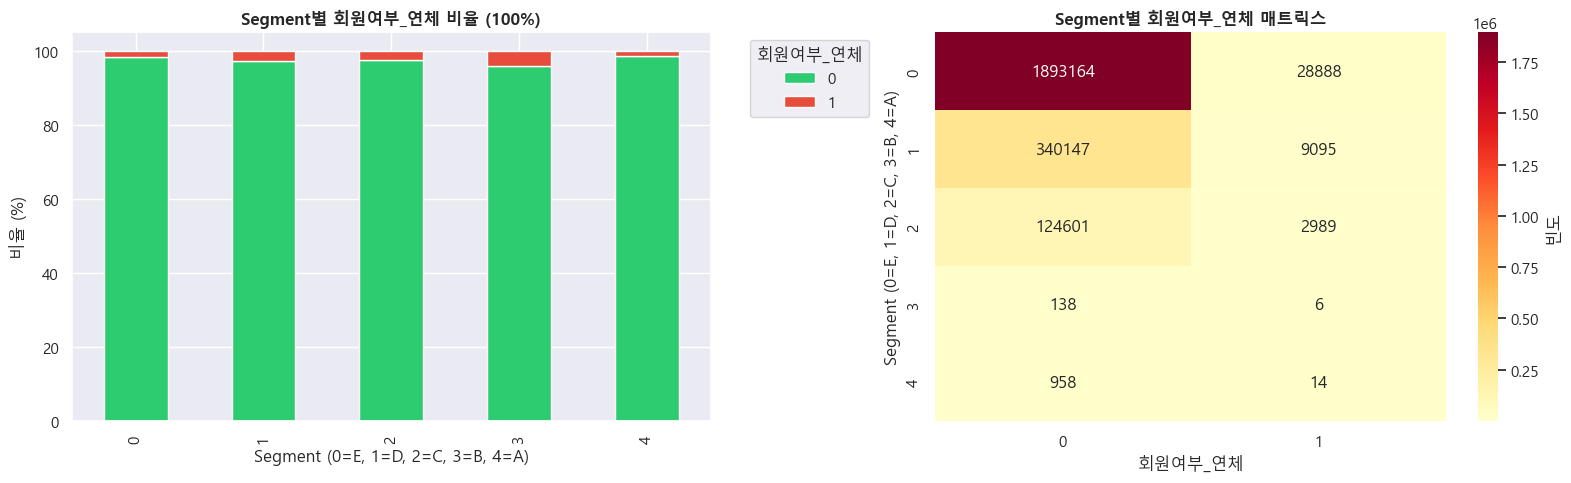

In [24]:
plot_segment_comparison(df, "회원여부_연체")

- 연체여부를 통해 A, B를 골라낼 수 있지 않을까 했는데, 아니었다.

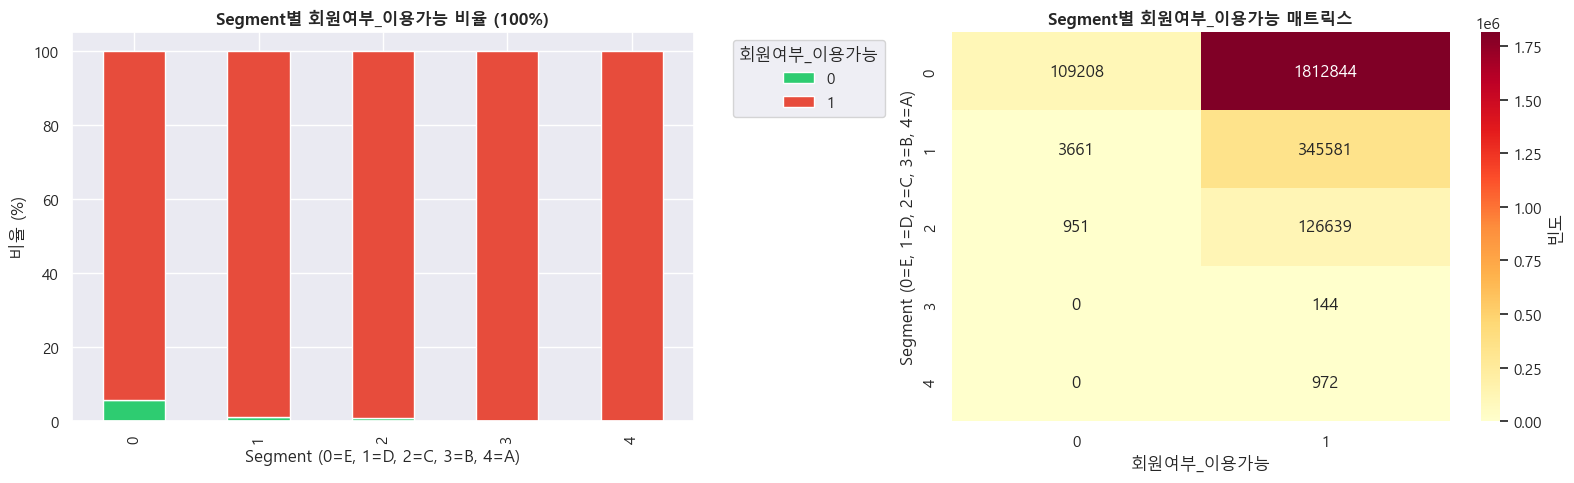

In [25]:
plot_segment_comparison(df, "회원여부_이용가능")

- 이용가능 여부는 확실하게 A, B를 걸러내고 있다. 이를 이용하면 안그래도 적은 표본의 A, B에 대해서 높은 점수를 낼 수 있지 않을까?

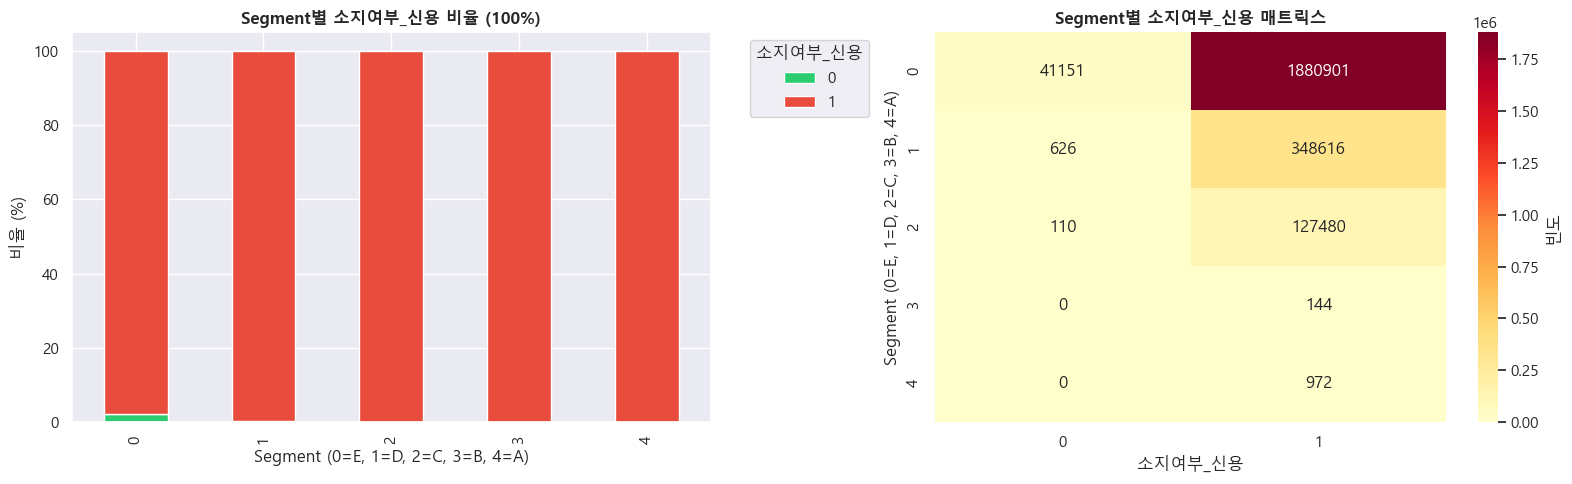

In [26]:
plot_segment_comparison(df, "소지여부_신용")

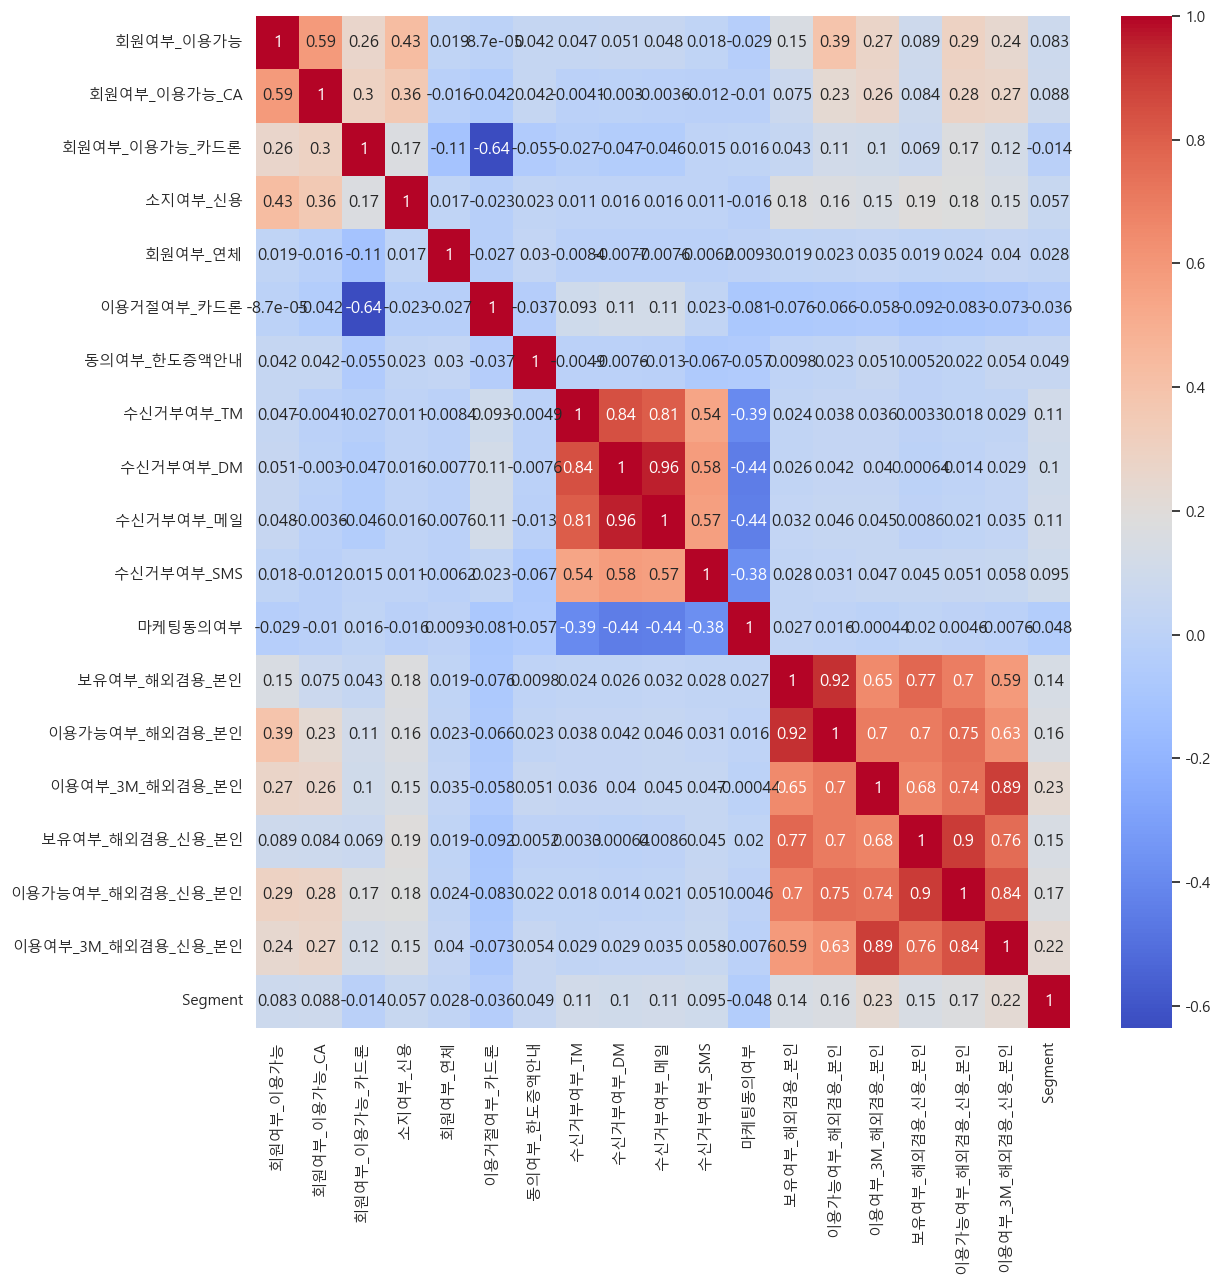

In [30]:
result_df = pd.concat([find_R(df, "여부"), df[["Segment"]]], axis=1)
plt.figure(figsize=(13, 13))
sns.heatmap(result_df.corr(), annot=True, cmap='coolwarm')
plt.tight_layout()
plt.show()

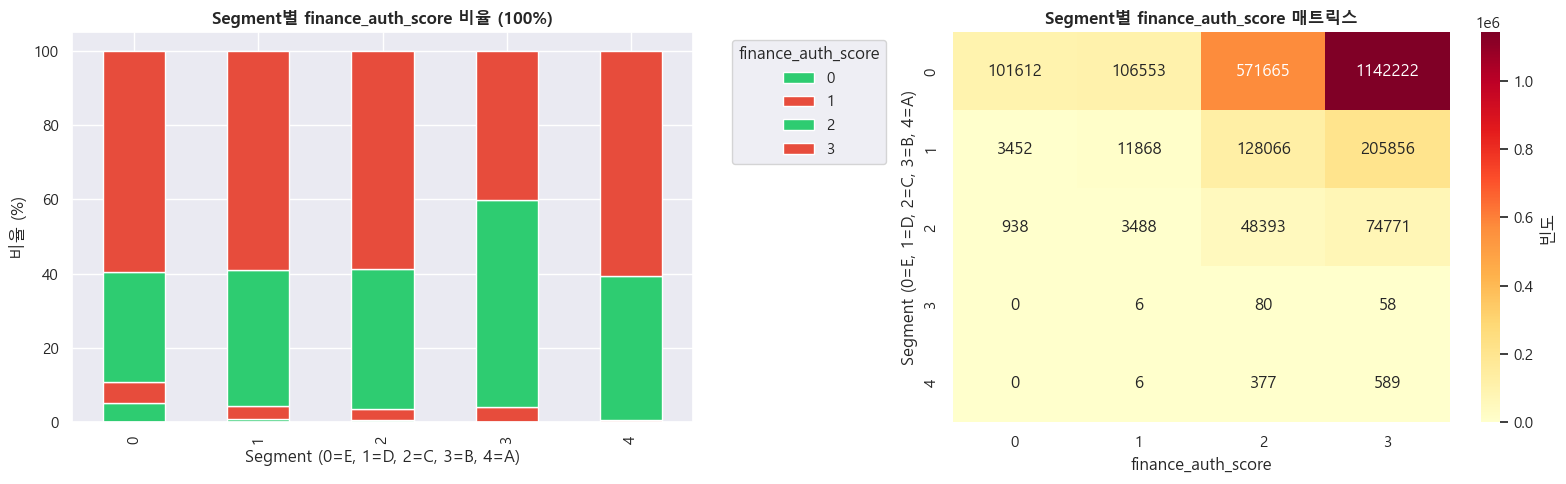

,finance_auth_score,Segment
finance_auth_score,1.000000,0.050415
Segment,0.050415,1.000000


In [42]:
df['finance_auth_score'] = (
    (df['회원여부_이용가능'] == 1).astype(int) + 
    (df['회원여부_이용가능_CA'] == 1).astype(int) + 
    (df['회원여부_이용가능_카드론'] == 1).astype(int)
)
_drop2.append("회원여부_이용가능")
_drop2.append("회원여부_이용가능_CA")
_drop2.append("회원여부_이용가능_카드론")
plot_segment_comparison(df, "finance_auth_score")
df[["finance_auth_score", "Segment"]].corr()

In [45]:
(df["회원여부_이용가능"] == 1).value_counts()
(df['회원여부_이용가능'] == '1').astype(int)

회원여부_이용가능
True     2286180
False     113820
Name: count, dtype: int64

# 피쳐 엔지니어링(1만 해봐서, important한것만 뽑아보려고 해보는 중)

In [58]:
column_list = []
corr_maker(df, filename = "_1st_corr.txt")
_1st_corr = read_corr(filename = "_1st_corr.txt")
_1st_corr = filter_high_corr(_1st_corr)
for corr in _1st_corr:
    add_list(column_list, corr[0])
column_list

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19828\1076769718.py:10: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  obj_cols = temp_df.select_dtypes(include=['object']).columns


결과가 _1st_corr.txt에 저장되었습니다.
이용금액_R3M_신용체크     0.622827
이용금액_R3M_신용       0.589032
_1순위카드이용금액        0.573870
_2순위카드이용금액        0.400225
이용카드수_신용체크        0.397713
                    ...   
할인금액_제휴연회비_B0M         NaN
상품관련면제카드수_B0M          NaN
임직원면제카드수_B0M           NaN
우수회원면제카드수_B0M          NaN
기타면제카드수_B0M            NaN
Name: Segment, Length: 76, dtype: float64


['이용금액_R3M_신용체크',
 '이용금액_R3M_신용',
 '_1순위카드이용금액',
 '_2순위카드이용금액',
 '이용카드수_신용체크',
 '_1순위카드이용건수',
 '이용카드수_신용',
 '_2순위카드이용건수',
 '이용가능카드수_신용',
 '이용가능카드수_신용체크',
 '유효카드수_신용',
 '유효카드수_신용체크',
 '소지카드수_유효_신용',
 '소지카드수_이용가능_신용',
 '입회경과개월수_신용',
 '_2순위신용체크구분',
 '이용금액_R3M_신용_가족',
 '이용여부_3M_해외겸용_본인',
 '이용여부_3M_해외겸용_신용_본인',
 '이용카드수_신용_가족',
 '유효카드수_신용_가족',
 '이용가능카드수_신용_가족',
 '이용금액_R3M_체크',
 '입회일자_신용']

In [81]:
trained_df = df[column_list].copy()
trained_df = trained_df.drop("입회일자_신용", axis=1)
trained_df = pd.concat([trained_df,pd.DataFrame(df["finance_auth_score"])], axis=1)
trained_df = pd.concat([trained_df,pd.DataFrame(df["Segment"])], axis=1)
trained_df["_2순위신용체크구분"] = pd.factorize(trained_df["_2순위신용체크구분"])[0]

# catboost를 통해서 피쳐엔지니어 뽑아내기

In [82]:
trained_df

,이용금액_R3M_신용체크,이용금액_R3M_신용,_1순위카드이용금액,_2순위카드이용금액,이용카드수_신용체크,_1순위카드이용건수,이용카드수_신용,_2순위카드이용건수,이용가능카드수_신용,이용가능카드수_신용체크,...,_2순위신용체크구분,이용금액_R3M_신용_가족,이용여부_3M_해외겸용_본인,이용여부_3M_해외겸용_신용_본인,이용카드수_신용_가족,유효카드수_신용_가족,이용가능카드수_신용_가족,이용금액_R3M_체크,finance_auth_score,Segment
0,196,196,3681,0,1,26,1,0,1,2,...,0,0,0,0,0,0,0,0,2,1
1,13475,13475,13323,0,1,46,1,0,1,1,...,-1,0,0,0,0,0,0,0,3,0
2,23988,23988,24493,0,1,28,1,0,1,2,...,0,0,0,0,0,0,0,0,2,2
3,3904,3904,5933,0,1,1,1,0,2,3,...,0,0,1,1,0,0,0,0,2,1
4,1190,0,0,0,1,-2,0,0,1,2,...,0,0,1,0,0,0,0,1190,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,10755,7267,5640,0,1,3,0,0,1,2,...,0,0,1,0,0,0,0,3488,3,0
399996,27636,27636,26357,0,1,38,1,0,1,1,...,-1,0,1,1,0,0,0,0,3,1
399997,23187,23187,17171,0,1,33,1,0,1,1,...,-1,0,1,1,0,0,0,0,2,2
399998,0,0,0,0,0,-2,0,0,1,1,...,-1,0,0,0,0,0,0,0,3,0


In [83]:
# train 데이터 준비
train = trained_df.copy()
X_train = train.drop('Segment', axis=1)
y_train = train['Segment']

# test 데이터 준비 (샘플로 train에서 분리)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify = y_train)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# 글로벌 변수로 best model 저장
best_model = None

# CatBoost 하이퍼파라미터 튜닝
def objective_cat(trial):
    global best_model
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'eval_metric' : "MultiClass",
        'verbose': 0,
        'task_type': 'GPU',
        'devices': '0'
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = f1_score(y_test, pred, average='weighted')
    
    # Best model 저장
    if best_model is None or score > best_f1_score:
        best_model = model
        best_f1_score = score
    
    return score

best_f1_score = 0
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=50)
print("Best CatBoost params:", study_cat.best_params)
print("Best CatBoost score:", study_cat.best_value)

[I 2026-02-06 15:43:08,209] A new study created in memory with name: no-name-fe51cc7b-3849-48cf-8c0f-e5ca6ba40dd8
[I 2026-02-06 15:43:10,594] Trial 0 finished with value: 0.8412126700177157 and parameters: {'iterations': 113, 'depth': 4, 'learning_rate': 0.07000335821355712, 'l2_leaf_reg': 2.2584700972473213, 'border_count': 132}. Best is trial 0 with value: 0.8412126700177157.
[I 2026-02-06 15:43:14,031] Trial 1 finished with value: 0.8438471694214303 and parameters: {'iterations': 158, 'depth': 7, 'learning_rate': 0.07042575022618514, 'l2_leaf_reg': 5.835601785354643, 'border_count': 69}. Best is trial 1 with value: 0.8438471694214303.
[I 2026-02-06 15:43:21,151] Trial 2 finished with value: 0.8447895620546231 and parameters: {'iterations': 611, 'depth': 4, 'learning_rate': 0.1649383751445026, 'l2_leaf_reg': 7.657189251997946, 'border_count': 145}. Best is trial 2 with value: 0.8447895620546231.
[I 2026-02-06 15:43:27,776] Trial 3 finished with value: 0.8458236201289154 and parameter

In [ ]:
# Best 모델에서 Feature Importance 시각화 (재학습 불필요 - 이미 위에서 저장됨)
# Feature Importance 추출
feature_importance = best_model.get_feature_importance()
feature_names = X_train.columns

# DataFrame으로 변환
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Seaborn으로 시각화
plt.figure(figsize=(12, 8))
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

sns.barplot(data=importance_df, y='Feature', x='Importance', palette='viridis')
plt.title('CatBoost Feature Importance (Best Model)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Top 20 Feature 시각화 (Feature가 많을 경우)
if len(importance_df) > 20:
    plt.figure(figsize=(12, 8))
    sns.barplot(data=importance_df.head(20), y='Feature', x='Importance', palette='rocket')
    plt.title('CatBoost Top 20 Feature Importance (Best Model)', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()

# 상위 10개 Feature 출력
print("\n=== Top 10 Most Important Features ===")
print(importance_df.head(10))